In [41]:
# "https://drive.google.com/file/d/1euMCXnL4FhbYInSq-MMgli9JkJdZHNZ2/view?usp=sharing"

In [1]:
root = "../data/091221_two_hydro_pool/"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}
runs = [a.strip() for a in open(run_list) if a != '']

0_pretest
1_with_tapping
2_without_tapping


In [2]:
fs = 1e6
dt = 1.0 / fs

# Helpers

## Pico Loaders

In [3]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3, apply_abs=True):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n
        self.apply_abs = apply_abs

    def __call__(self, data):
        if self.apply_abs:
            if len(data.shape) == 1:
                return np.convolve(np.abs(data), self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
            return out
        else:
            if len(data.shape) == 1:
                return np.convolve(data, self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
            return out
            

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

    
import struct
class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None,  # {'fs': fs,},
                 preserve_chA=False,
                 num_channels=6
                ):  
        self.filename = filename
        self.file = None
        self.preserve_chA = preserve_chA
        self.num_channels = num_channels

        self.transformers = []
        if bp_args is not None:
            self.transformers.append(BP(**bp_args))
        if ma_args is not None:
            self.transformers.append(MA(**ma_args))
        if hil_args is not None:
            self.transformers.append(Hilbert(**hil_args))
    
    def open(self):
        if self.file is not None:
            self.close()
        
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)[:, :self.num_channels]
            dtype = arr.dtype
            
            if self.preserve_chA:
                chA = arr[:, 0].copy()
            
            for tran in self.transformers:
                arr = tran(arr)
            
            arr = arr.astype(dtype)
            if self.preserve_chA:
                arr[:, 0] = chA
            
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, ex_type, value, traceback):
        self.close()

In [8]:
import numpy as np
import subprocess
from tqdm.notebook import trange
# import functools

# def conditional(dec, condition):
#     def decorator(func):
#         if condition:    
#             return dec(func)
#         return func
#     return decorator

# @conditional(functools.cache, cache_processed_data)
def load_pico_file(filename, num_channels=6, max_chunks=np.inf):
    with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
        t0 = reader.get()[0]
    
    # WARNING: THIS IS A HACK! Note the magic numbers
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)
    num_chunks = min(num_chunks, max_chunks)
    chunk_size = PicoDataLoader.bufsize
    y = np.empty((chunk_size * num_chunks, num_channels))
    index = 0
    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, preserve_chA=True,
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args=None,  #{'fs': fs, 'dt': 6e-5},
                 hil_args={'fs': fs,},
                 num_channels=num_channels,
                       ) as reader:
        try:
            for i in trange(num_chunks):
                t, y[index:index + chunk_size, ...] = reader.get()
                index += chunk_size
                t_curr += dt * chunk_size
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
    t = np.arange(y.shape[0]) * dt

    t.flags.writeable = False
    y.flags.writeable = False

    return t, y

## Indices

In [5]:
def get_ping_indices(ping_ch, fs=fs, pinger_zc_thresh=-1000, min_down_length=0.350):
    ping_ch = ping_ch.copy()
    ping_ch[0] = 0
    ping_ch[-1] = 0


    on = ping_ch < pinger_zc_thresh
    diff = np.diff(on.astype('int'))
    down = np.where(diff > 0)[0]
    up = np.where(diff < 0)[0]

    correct_mask = (up - down) > fs * min_down_length
    # 0.350 ~= 0.8 * (t_between_ping / 2)

    down = down[correct_mask]
    # down += 1  # For the diff
    
    del ping_ch  # Do we really need to?
    return down

## Ranges

In [6]:
def get_simple_zc(ch, zero_crossing_thresh=250):
    # For boolean arrays it short circuits and returns the index of the first `True`. If no `True`, it returns `0` 
    return np.argmax(ch > zero_crossing_thresh, axis=0) 

In [7]:
def get_ranges(hydro, ping_index, fs=fs, max_dist=10, ping_size=5e-3, v_sound=1480):
    ping_len = max_dist / v_sound + ping_size
    win = slice(ping_index, ping_index + int(fs * ping_len))
    ranges = np.zeros((hydro.shape[1],))
    for i, row in enumerate(hydro[win, :].T):
        zero_in = get_simple_zc(row, zero_crossing_thresh=400)  # Est_ZC_stage_1(row)
        if zero_in <= 0: 
            zero_in = np.nan
        ranges[i] = zero_in * v_sound / fs
        if ranges[i] < 0:
            print(zero_in,v_sound, fs)
            raise Exception()
        if ranges[i] > max_dist:
            ranges[i] = np.nan
    return ranges

# Load Run

In [9]:
run = runs[1]  #runs[8]
run

'1_with_tapping'

In [10]:
pico_file = f"{root}/{run}/pico.npts"
!du -h {pico_file}

2.9G	../data/091221_two_hydro_pool//1_with_tapping/pico.npts


In [12]:
t, y = load_pico_file(pico_file, max_chunks=int(100 * fs / PicoDataLoader.bufsize))


  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
y = y[:, :3]

In [14]:
t[-1], y.shape

(99.999999, (100000000, 3))

In [15]:
indices = get_ping_indices(y[:, 0])

In [16]:
ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]
indices.shape, ranges.shape

((98,), (86, 2))

In [17]:
np.mean(ranges, axis=0)

array([1.67040372, 1.62913581])

In [18]:
import matplotlib.pyplot as plt

array([1.66648, 1.64576])

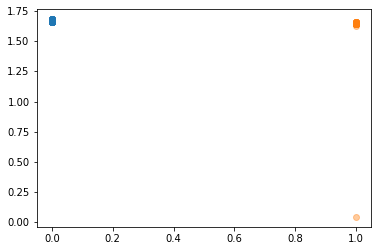

In [19]:
for i, ran in enumerate(ranges.T):
    plt.plot(np.ones_like(ran)*i, ran, 'o', alpha=0.4)
np.percentile(ranges, 50, axis=0)

In [40]:
diff = ranges[:, 0] - ranges[:, 1]
diff.shape, diff.mean(), np.percentile(diff, 50), diff.std()

((86,), 0.041267906976744234, 0.019240000000000146, 0.17176401107411993)

In [ ]:
plt.boxplot(np.clip(diff, np.percentile(diff, 10), np.percentile(diff, 90)))

In [32]:
np.percentile(ranges[:, 0] - ranges[:, 1], 50)

0.019240000000000146

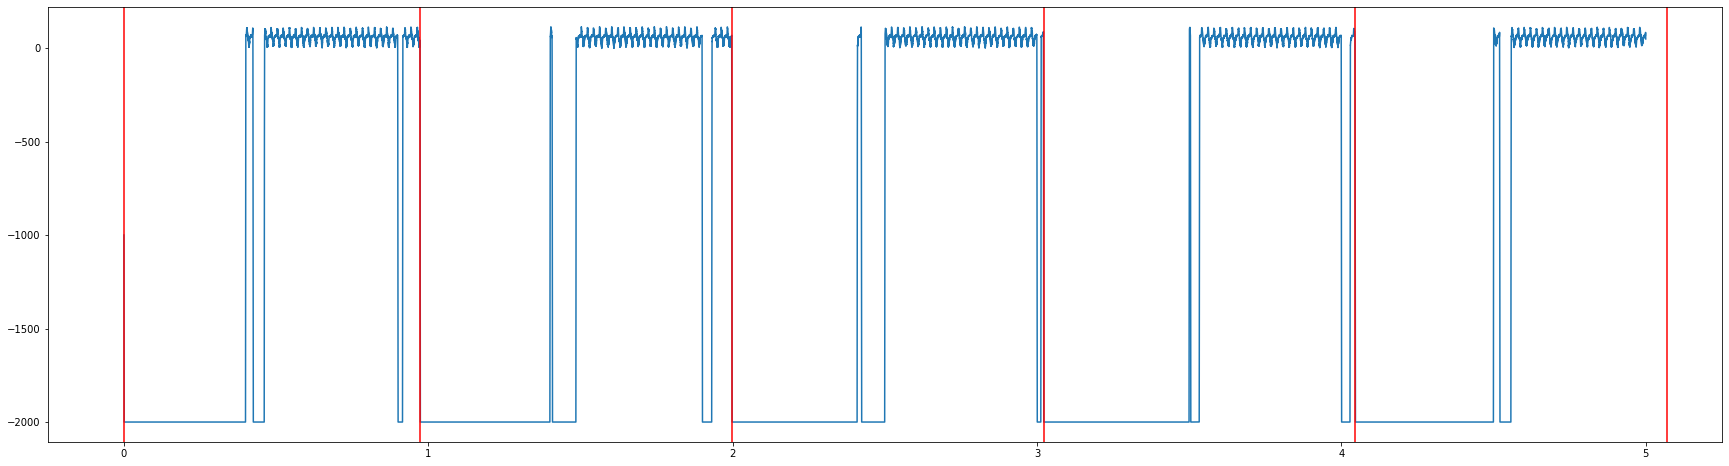

In [20]:
plt.figure(figsize=(30,8))
win = slice(0, int(fs * 5))
plt.plot(t[win], MA(apply_abs=False)(y[win, 0]))
plt.xlim(*plt.xlim())
for ttt in indices * dt:
    plt.axvline(ttt, color='red')

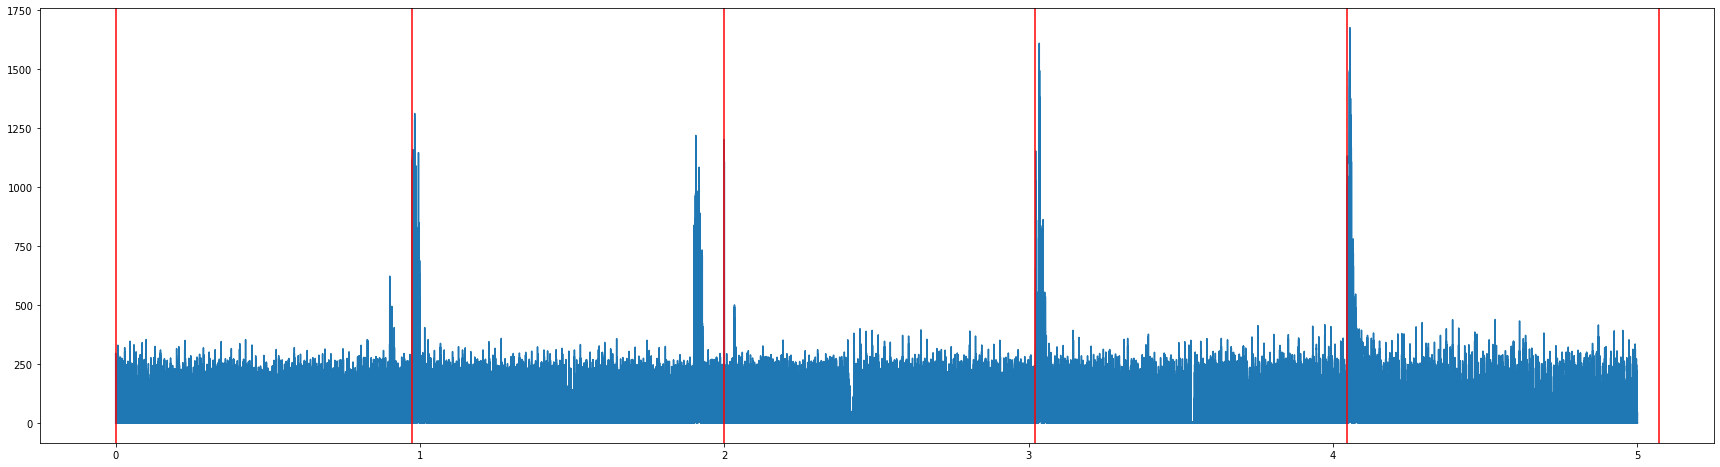

In [21]:
plt.figure(figsize=(30,8))
win = slice(0, int(fs * 5))
plt.plot(t[win], (y[win, 1]))
plt.xlim(*plt.xlim())
for ttt in indices * dt:
    plt.axvline(ttt, color='red')

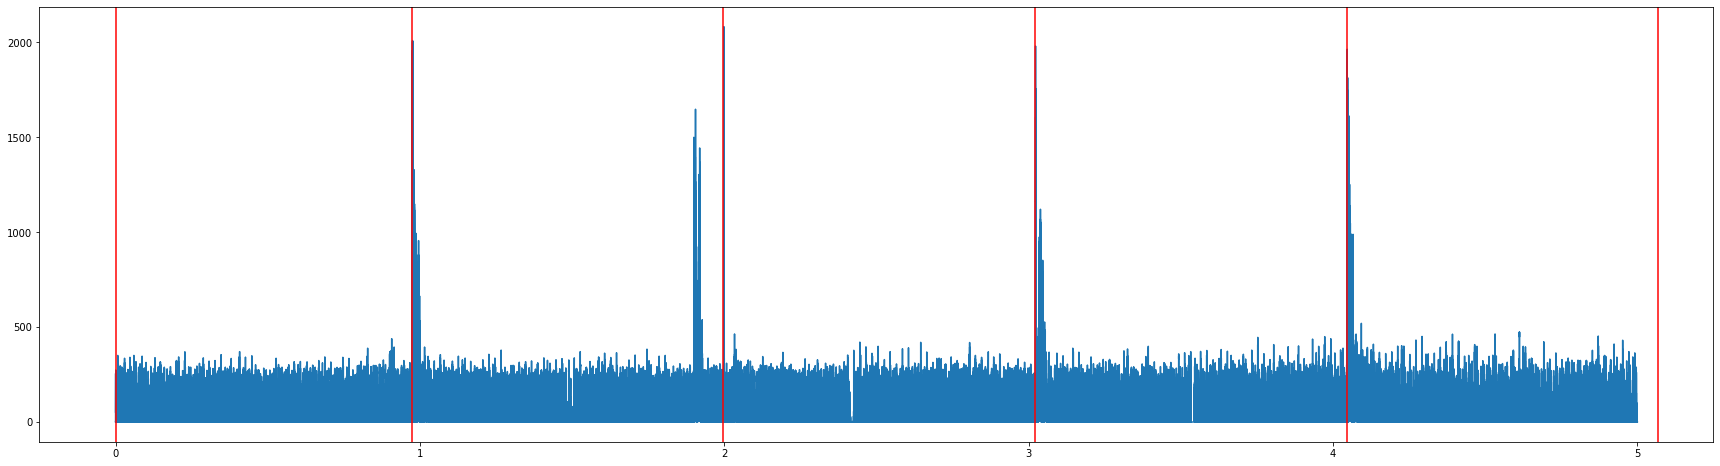

In [22]:
plt.figure(figsize=(30,8))
win = slice(0, int(fs * 5))
plt.plot(t[win], (y[win, 2]))
plt.xlim(*plt.xlim())
for ttt in indices * dt:
    plt.axvline(ttt, color='red')

1.66648

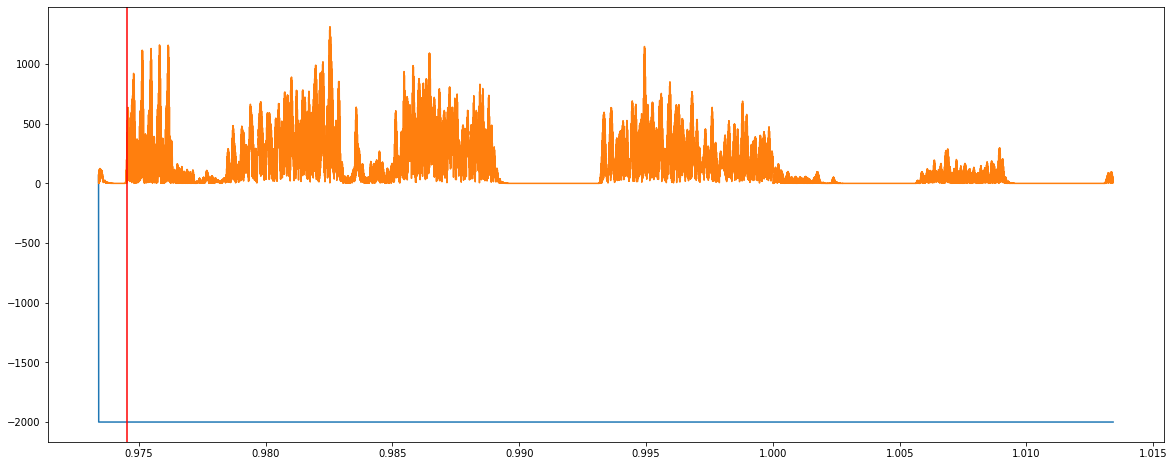

In [23]:
plt.subplots(1,1, figsize=(20,8))
win = slice(indices[1], indices[1] + int(fs * 40e-3))
plt.plot(t[win], y[win, 0])
plt.plot(t[win], y[win, 1])
plt.axvline(t[win][get_simple_zc(y[win, 1], zero_crossing_thresh=400)], color='red')
get_simple_zc(y[win, 1], zero_crossing_thresh=400) * dt * 1480

1.64724

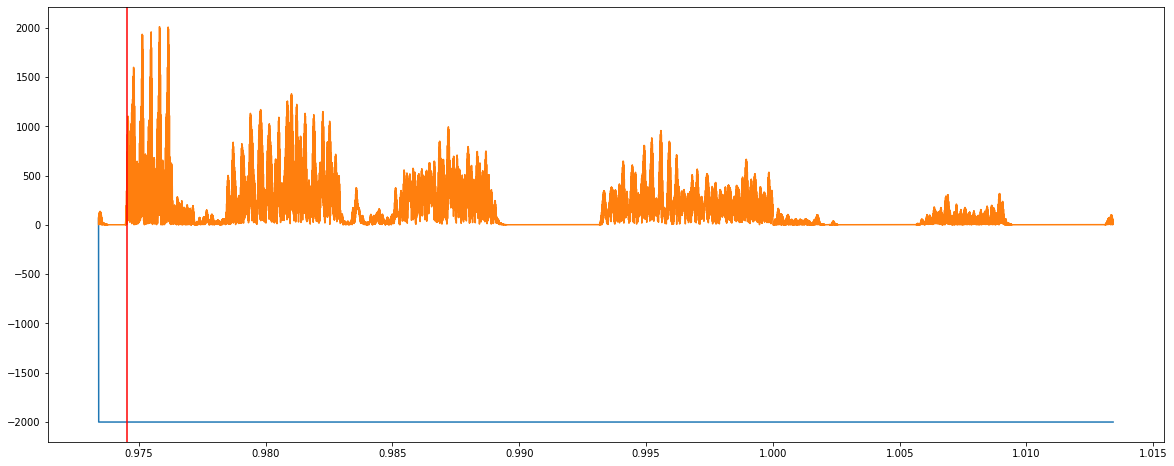

In [24]:
plt.subplots(1,1, figsize=(20,8))
win = slice(indices[1], indices[1] + int(fs * 40e-3))
plt.plot(t[win], y[win, 0])
plt.plot(t[win], y[win, 2])
plt.axvline(t[win][get_simple_zc(y[win, 2], zero_crossing_thresh=400)], color='red')
get_simple_zc(y[win, 2], zero_crossing_thresh=400) * dt * 1480

In [ ]:
indices * dt

In [25]:
del t, y

In [30]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           11Gi       2.3Gi       6.7Gi       291Mi       2.5Gi       8.7Gi
Swap:          31Gi       251Mi        31Gi
